# Table Of Content:

- <a href="#feat">1. Feature Engineering:</a>
    - <a href="#feat1">1.1 Companys' Popularity</a>
    - <a href="#feat2">1.2 Car Model Level</a>
    - <a href="#feat3">1.3 One hot Encoding</a>
- <a href="#featsel">2. Feature Seletion</a>
- <a href="#model">3. Model Selection:</a>
    - <a href="#model1">3.1 Linear Regression</a>
    - <a href="#model2">3.2 Decision Tree</a>
    - <a href="#model3">3.3 Random Forest</a>
- <a href="#expl">4. Model Intrepretability:</a>
    - <a href="#expl1">4.1 Permoutation Importance</a>
    - <a href="#expl3">4.2 Partial Dependancy Plots</a>
- <a href="#eval">5. Model Evaluation:</a>
    - <a href="#eval1">5.1 Linear Regression</a>
    - <a href="#eval2">5.2 Decision Tree</a>
    - <a href="#eval3">5.3 Random Forest</a>
    - <a href="#eval4">5.4 Final Results and conclusion</a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
%matplotlib inline
import warnings
import shap
warnings.filterwarnings('ignore')

In [3]:
# Loading Data
data = pd.read_csv("semi_master_date.csv")

<span id="feat"></span>
## 1. More Feature Engineering:

Here We assume that replacing the high cardinality categorical variables with lower one can enhance the model performance, and we will check this in the model evaluation step.

<span id="feat1"></span>
### 1.1 Company's Popularity:

Adding a new feature to the data that represents the popularity of the company that made the car in that time, and because we have two data sets, then this will be changed from one dataset to other, and the popularity can be found that by knowing the volume of sold car from that brand inside USA at two separate times, one 2006(Old) dataset and the other for 2018(New).

And this feature will have three levels that represents the popularity as follow:
- 3: The most 10 popular companys, those who sold the most in (2006 and 2018 separately)
- 2: The medium 20 Companys in popularity
- 1: other brands.

###### Resources to help:
- For 2006 Sellers: 
    - https://www.goodcarbadcar.net/2006-usa-auto-sales-rankings-by-mode/
    - https://knoema.com/infographics/floslle/top-vehicle-manufacturers-in-the-us-market-1961-2016
- For 2018 Sellers: 
    - https://www.goodcarbadcar.net/u-s-auto-sales-brand-rankings-september-2018-ytd/


In [4]:
# new_data_train

In [5]:
data.Make.value_counts().describe()

count        55.000000
mean      21342.690909
std       34911.596398
min           1.000000
25%         220.000000
50%        4969.000000
75%       26264.000000
max      154109.000000
Name: Make, dtype: float64

In [6]:
popular_brands = data.Make.value_counts()[data.Make.value_counts() >= 26264]
medium_brands = data.Make.value_counts()[(data.Make.value_counts() < 26264) & (data.Make.value_counts() >= 220)]

In [9]:
popular_brands.to_csv("popular_brands.csv")
medium_brands.to_csv("medium_brands.csv")

In [11]:
def add_seller_popularity(df, top10, medium):
    def popullariy(brand, top = top10, med = medium):
        if(brand in top):
            return 3
        elif(brand in med):
            return 2
        else:
            return 1
    df["Brand_popularity"] = df["Make"].apply(popullariy)
    return df

In [12]:
new_data = add_seller_popularity(data, popular_brands, medium_brands)

In [13]:
new_data.head()

,Price,Year,Mileage,City,State,Make,Model,Usage_level,City_imporatnce,City_mean_price,State_imporatnce,Brand_popularity
0,16472,2015,18681,JEFFERSON CITY,MO,BUICK,ENCORECONVENIENCE,Low,High,18785.571605,Medium,2
1,15749,2015,27592,HIGHLAND,IN,BUICK,ENCOREFWD,Medium,High,18233.158996,Medium,2
2,16998,2015,13650,BOONE,NC,BUICK,ENCORELEATHER,Low,High,22329.498000,High,2
3,15777,2015,25195,NEW ORLEANS,LA,BUICK,ENCOREFWD,Medium,High,19024.911538,Medium,2
4,16784,2015,22800,LAS VEGAS,NV,BUICK,ENCORECONVENIENCE,Low,High,18866.277499,Medium,2


In [14]:
new_data.shape

(1173848, 12)

<span id="feat2"></span>
### 1.2 Car Model Level:

Adding a new feature that represents luxury (mean price) of a certain model and divide these models into 3 main categories:
- 3: The most 10 Luxury Models, those who has the most 10 mea prices.
- 2: The medium 20 Luxury Car Models
- 1: Other Models.

In [17]:
new_Models = new_data.groupby("Model")["Price"].mean().sort_values(ascending = False)

In [19]:
new_Models.describe()

count     2914.000000
mean     20460.776204
std      14034.303934
min       1977.000000
25%       9702.927984
50%      16911.044828
75%      27555.195701
max      66999.000000
Name: Price, dtype: float64

In [21]:
top_models = new_Models[new_Models >= 27555 ]
medium_models = new_Models[(new_Models < 27555) & (new_Models >= 9702 )]

In [31]:
top_models.to_csv("top_models.csv")
medium_models.to_csv("medium_models.csv")

In [22]:
top_models

Model
57S4DR                66999.000000
3602DR                66995.000000
GLEAMG                66982.000000
XFR-S                 66898.000000
A7COMPETITION         66148.500000
                          ...     
BRZSERIES.YELLOW      27580.000000
XTSPLATINUM           27576.423423
CAYMAN2DR             27568.300885
PATHFINDERPLATINUM    27567.260108
SIENNASE              27555.314394
Name: Price, Length: 729, dtype: float64

In [23]:
def add_model_level(df, top, medium):
    def model_level(model, t = top, med = medium):
        if(model in t):
            return 3
        elif(model in med):
            return 2
        else:
            return 1
    df["Model_level"] = df["Model"].apply(model_level)
    return df

In [24]:
new_data = add_model_level(new_data, top_models.index.to_list(), medium_models.index.to_list())

In [25]:
new_data.head()

,Price,Year,Mileage,City,State,Make,Model,Usage_level,City_imporatnce,City_mean_price,State_imporatnce,Brand_popularity,Model_level
0,16472,2015,18681,JEFFERSON CITY,MO,BUICK,ENCORECONVENIENCE,Low,High,18785.571605,Medium,2,2
1,15749,2015,27592,HIGHLAND,IN,BUICK,ENCOREFWD,Medium,High,18233.158996,Medium,2,2
2,16998,2015,13650,BOONE,NC,BUICK,ENCORELEATHER,Low,High,22329.498000,High,2,2
3,15777,2015,25195,NEW ORLEANS,LA,BUICK,ENCOREFWD,Medium,High,19024.911538,Medium,2,2
4,16784,2015,22800,LAS VEGAS,NV,BUICK,ENCORECONVENIENCE,Low,High,18866.277499,Medium,2,2


<span id="feat3"></span>
### 1.3 One Hot Encoding for categorical values:

In [27]:
# Drop High Cardinality columns 
new_data = new_data.drop(columns = ["Make", "Model", "City"])

In [28]:
new_data

,Price,Year,Mileage,State,Usage_level,City_imporatnce,City_mean_price,State_imporatnce,Brand_popularity,Model_level
0,16472,2015,18681,MO,Low,High,18785.571605,Medium,2,2
1,15749,2015,27592,IN,Medium,High,18233.158996,Medium,2,2
2,16998,2015,13650,NC,Low,High,22329.498000,High,2,2
3,15777,2015,25195,LA,Medium,High,19024.911538,Medium,2,2
4,16784,2015,22800,NV,Low,High,18866.277499,Medium,2,2
...,...,...,...,...,...,...,...,...,...,...
1173843,16490,2013,28969,WA,Medium,Medium,20844.530726,High,3,2
1173844,14990,2013,61299,CT,Medium,High,15260.520067,Medium,3,2
1173845,17909,2013,36275,NC,Medium,High,22261.401575,High,3,2
1173846,18995,2013,43079,TX,Medium,Medium,26688.596491,High,3,2


In [30]:
import pickle

In [34]:
def oh_encoder(df):
    num_cols = df.select_dtypes(exclude = "object").columns.to_list()
    object_cols = df.select_dtypes("object" ).columns.to_list()
    
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    OH_train = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
    cols = list(OH_encoder.get_feature_names_out())    
    
    
    OH_train.index = df.index
    
    OH_train.columns = list(cols)
    
    with open("encoder.pkl", "wb") as f: 
        pickle.dump(OH_encoder, f)

    
    
    f_data = pd.concat([OH_train, df[num_cols]], axis = 1)
    
    return f_data

In [35]:
#New Cars Data
final_data = oh_encoder(new_data)

In [37]:
final_data.head()

,State_ AK,State_ AL,State_ AR,State_ AZ,State_ CA,State_ CO,State_ CT,State_ DC,State_ DE,State_ FL,...,City_imporatnce_Medium,State_imporatnce_High,State_imporatnce_Low,State_imporatnce_Medium,Price,Year,Mileage,City_mean_price,Brand_popularity,Model_level
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,16472,2015,18681,18785.571605,2,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,15749,2015,27592,18233.158996,2,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,16998,2015,13650,22329.498000,2,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,15777,2015,25195,19024.911538,2,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,16784,2015,22800,18866.277499,2,2


In [40]:
#Exporting to Files:
final_data.to_csv("final_master_data.csv", index = False)

In [39]:
f_data = final_data.drop(columns = ["Price"])
f_target = final_data.Price

In [43]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(f_data, f_target, test_size = 0.15, shuffle= True)

In [96]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_data)
X_train_std = scaler.transform(train_data)

scaler.fit(test_data)
X_test_std = scaler.transform(test_data)

In [99]:
X_train_std = pd.DataFrame(X_train_std, columns = train_data.columns.to_list())
X_test_std = pd.DataFrame(X_test_std, columns = test_data.columns.to_list())

In [101]:
X_train_std.to_csv("final_train_data_normalized.csv", index = False)
X_test_std.to_csv("final_test_data_normalized.csv", index = False)
# train_target.to_csv("final_train_target.csv", index = False)
# test_target.to_csv("final_test_target.csv", index = False)

<span id="featsel"></span>
## 2. Feature Selection:

Selecting the most relevant features by Lasso Regression or Correlation tests. 

In [46]:
# new_train_data   = pd.read_csv("new_data/train_new_data_f.csv")
# new_target_train = pd.read_csv("new_data/train_new_taget.csv")
# new_test_data    = pd.read_csv("new_data/test_new_data_f.csv")
# new_target_test  = pd.read_csv("new_data/test_new_target.csv")

# Creaiting Poly features


In [207]:
# def poly_feat(df, features):
#     pf = PolynomialFeatures(degree = 2, include_bias = False)
#     fit_trans = pf.fit_transform(df[features])
#     cols = pf.get_feature_names_out()
#     df_fitted = pd.DataFrame(fit_trans, columns = cols)
#     df1 = df.drop(columns = features)
#     final_df = pd.concat([df1, df_fitted], axis = 1)
#     final_df = final_df.drop(columns = ['Mileage Year', 'Mileage Brand_popularity', 'Year Brand_popularity'])
#     return final_df

In [208]:
# poly_features = ["Mileage", "Year", "Brand_popularity"]

In [47]:
# new_train_data_poly = poly_feat(new_train_data, poly_features)
# new_test_data_poly = poly_feat(new_test_data, poly_features)
# old_train_data_poly= poly_feat(old_train_data, poly_features)
# old_test_data_poly = poly_feat(old_test_data, poly_features)

<span id="model"></span>
## 3. Model Selection:

We build the each models for the two separate datasets old and new cars, by selecting the most relevant hyper parameters in the training and validation sets.

<span id="model1"></span>
### 3.1 Linear Regression:

In [102]:
LR_new = Ridge()
parameters = {"alpha": [0, 0.1, 1, 10, 100]}

GS = GridSearchCV(LR_new, parameters, scoring= "r2", cv = 5, verbose = 3.1)

GS.fit(X_train_std, train_target)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................alpha=0;, score=0.608 total time=  49.1s
[CV 2/5] END ...........................alpha=0;, score=0.607 total time=   4.2s
[CV 3/5] END ...........................alpha=0;, score=0.609 total time=   3.1s
[CV 4/5] END ...........................alpha=0;, score=0.608 total time=   3.0s
[CV 5/5] END ...........................alpha=0;, score=0.607 total time=   2.8s
[CV 1/5] END .........................alpha=0.1;, score=0.608 total time=   1.1s
[CV 2/5] END .........................alpha=0.1;, score=0.607 total time=   0.6s
[CV 3/5] END .........................alpha=0.1;, score=0.609 total time=   0.5s
[CV 4/5] END .........................alpha=0.1;, score=0.608 total time=   0.6s
[CV 5/5] END .........................alpha=0.1;, score=0.607 total time=   0.5s
[CV 1/5] END ...........................alpha=1;, score=0.608 total time=   0.5s
[CV 2/5] END ...........................alpha=1;,

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 0.1, 1, 10, 100]}, scoring='r2',
             verbose=3.1)

In [103]:
GS.best_params_

{'alpha': 10}

All of them has the same r2 scrores so we will choose alpha = 1

In [104]:
Ridge_model = Ridge(alpha = 10, random_state = 1)
Ridge_model.fit(X_train_std, train_target)
predictions_ridge_new = Ridge_model.predict(X_test_std)

In [107]:
Ridge_model.score(X_train_std, train_target)

0.6080448447788321

In [108]:
Ridge_model.score(X_test_std, test_target)

0.5777980343734019

In [59]:
with open("Ridge.pkl", "wb") as f: 
    pickle.dump(Ridge_model, f)

<span id="model2"></span>
### 3.2 Decision Tree:

In [109]:
DT_new = DecisionTreeRegressor()
parameters = {"max_depth": [3,5, 10, 11,12, 13, 14, 15]}

GS = GridSearchCV(DT_new, parameters, scoring= "r2", cv = 5, verbose = 3.1)

GS.fit(X_train_std, train_target)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .......................max_depth=3;, score=0.613 total time=   2.2s
[CV 2/5] END .......................max_depth=3;, score=0.612 total time=   2.1s
[CV 3/5] END .......................max_depth=3;, score=0.614 total time=   2.1s
[CV 4/5] END .......................max_depth=3;, score=0.614 total time=   2.1s
[CV 5/5] END .......................max_depth=3;, score=0.612 total time=   2.1s
[CV 1/5] END .......................max_depth=5;, score=0.647 total time=   3.4s
[CV 2/5] END .......................max_depth=5;, score=0.647 total time=   3.6s
[CV 3/5] END .......................max_depth=5;, score=0.649 total time=   3.8s
[CV 4/5] END .......................max_depth=5;, score=0.649 total time=   3.6s
[CV 5/5] END .......................max_depth=5;, score=0.647 total time=   3.5s
[CV 1/5] END ......................max_depth=10;, score=0.670 total time=   7.1s
[CV 2/5] END ......................max_depth=10;,

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 5, 10, 11, 12, 13, 14, 15]},
             scoring='r2', verbose=3.1)

In [110]:
GS.best_params_

{'max_depth': 11}

In [111]:
DT_new = DecisionTreeRegressor(max_depth = 11, random_state = 1)
DT_new.fit(X_train_std, train_target)
predictions_DT_new = DT_new.predict(X_test_std)

In [82]:
with open("DT.pkl", "wb") as f: 
    pickle.dump(DT_new, f)

<span id="model3"></span>
### 3.3 Random Forest:

In [112]:
RF_new = RandomForestRegressor()
prarmaeters = {
    "max_depth": [11],
    "n_estimators": [1,10,20,30]
}
GS = GridSearchCV(RF_new, prarmaeters, scoring= "r2", cv = 5, verbose = 3.1)

GS.fit(X_train_std, train_target)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ......max_depth=11, n_estimators=1;, score=0.667 total time=   5.5s
[CV 2/5] END ......max_depth=11, n_estimators=1;, score=0.668 total time=   5.5s
[CV 3/5] END ......max_depth=11, n_estimators=1;, score=0.668 total time=   5.4s
[CV 4/5] END ......max_depth=11, n_estimators=1;, score=0.668 total time=   5.7s
[CV 5/5] END ......max_depth=11, n_estimators=1;, score=0.667 total time=   5.8s
[CV 1/5] END .....max_depth=11, n_estimators=10;, score=0.675 total time=  53.4s
[CV 2/5] END .....max_depth=11, n_estimators=10;, score=0.676 total time=  54.2s
[CV 3/5] END .....max_depth=11, n_estimators=10;, score=0.676 total time=  54.1s
[CV 4/5] END .....max_depth=11, n_estimators=10;, score=0.677 total time=  52.6s
[CV 5/5] END .....max_depth=11, n_estimators=10;, score=0.675 total time=  53.9s
[CV 1/5] END .....max_depth=11, n_estimators=20;, score=0.676 total time= 1.8min
[CV 2/5] END .....max_depth=11, n_estimators=20;,

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [11], 'n_estimators': [1, 10, 20, 30]},
             scoring='r2', verbose=3.1)

In [71]:
GS.best_params_

{'max_depth': 11, 'n_estimators': 30}

In [72]:
RF_new = RandomForestRegressor(max_depth = 10, n_estimators= 20, random_state = 1)
RF_new.fit(train_data, train_target)
predictions_RF_new = RF_new.predict(test_data)

In [73]:
with open("RF.pkl", "wb") as f: 
    pickle.dump(RF_new, f)

<span id="eval"></span>
## 5. Model Evaluation:

We Will use two metrics to help us evaluate the models in the two test sets:
- NRMSE: Normaalized root mean square value
- MAPE: Mean Absolute precentage error
- R2: Coeffecient of determination

<span id="eval1"></span>
### 5.1: Linear Regression:

In [67]:
#Ridge Regression Scores for new cars
mape_new_ridge_error = mean_absolute_percentage_error(test_target, predictions_ridge_new)
r2_new_ridge_score = r2_score(test_target, predictions_ridge_new)
nrmse_new_ridge_error = (1/float(test_target.max() - test_target.min()))*(mean_squared_error(test_target, 
                                                                                             predictions_ridge_new, 
                                                                                             squared = False))

In [65]:
rmse_ridge = mean_squared_error(test_target, predictions_ridge_new, squared = False)

In [66]:
rmse_ridge

6644.458354157875

In [68]:
nrmse_new_ridge_error

0.101404956262711

In [74]:
r2_new_ridge_score

0.6062564510705538

In [75]:
mape_new_ridge_error

0.3067212809206882

In [76]:
res_ridge_new = test_target - predictions_ridge_new

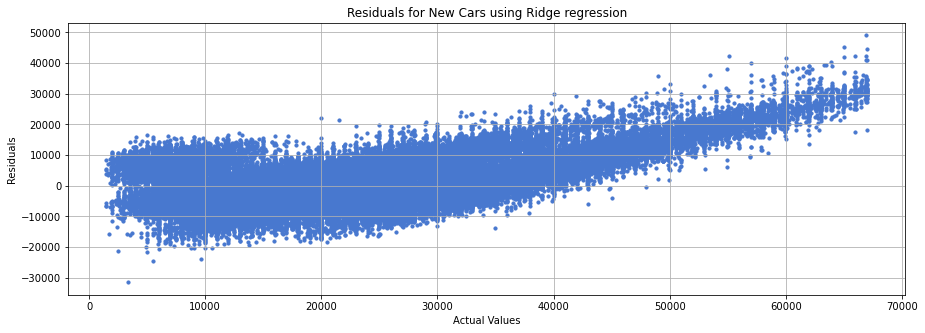

In [79]:
#Residual Plot
plt.figure(figsize = (15, 5))
plt.title("Residuals for New Cars using Ridge regression")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.scatter(test_target, res_ridge_new, s = 10)
plt.grid()
plt.style.use("seaborn-muted")
plt.show()

<span id="eval2"></span>
### 5.2 Decision Tree:

In [83]:
predictions_DT_new

array([25820.1115942 , 24198.16312057, 33010.57116105, ...,
       18001.03458647, 20672.10880772, 13910.12160068])

In [87]:
#Decision tree scores for new cars
mape_new_DT_error = mean_absolute_percentage_error(test_target, predictions_DT_new)
nrmse_new_DT_error = (1/float(test_target.max() - test_target.min()))*(mean_squared_error(test_target, 
                                                                                                  predictions_DT_new, 
                                                                                                  squared = False))
r2_new_DT_score = r2_score(test_target, predictions_DT_new)
rmse_DT = mean_squared_error(test_target, predictions_ridge_new, squared = False)

In [88]:
res_DT_new = test_target - predictions_DT_new

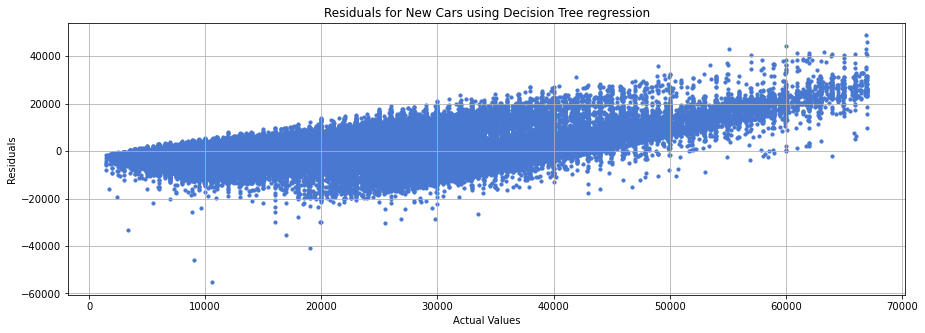

In [89]:
#Residual Plot
plt.figure(figsize = (15, 5))
plt.title("Residuals for New Cars using Decision Tree regression")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.scatter(test_target, res_DT_new, s = 10)
plt.grid()
plt.style.use("seaborn-dark-palette")
plt.show()

<span id="eval3"></span>
### 5.3 Random Forest:

In [90]:
#Random Forest Regression scores for new cars
mape_RF_new = mean_absolute_percentage_error(test_target, predictions_RF_new)
nrmse_RF_new_error = (1/float(test_target.max() - test_target.min()))*(mean_squared_error(test_target, 
                                                                                           predictions_RF_new, 
                                                                                           squared = False))
r2_new_RF_score = r2_score(test_target, predictions_RF_new)
rmse_RF = mean_squared_error(test_target, predictions_ridge_new, squared = False)

In [91]:
res_RF_new = test_target - predictions_RF_new

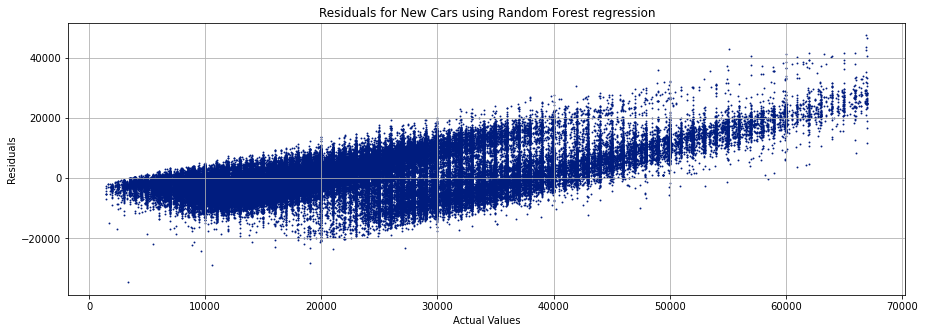

In [92]:
#Residual Plot
plt.figure(figsize = (15, 5))
plt.title("Residuals for New Cars using Random Forest regression")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.scatter(test_target, res_RF_new, s = 0.8)
plt.grid()
plt.style.use("seaborn-dark-palette")
plt.show()

<span id="eval4"></span>
### 5.4 Final Results and conclusions:

Showing the final accuracies for all models in the two dataset together in an evaluation table, to help us decide the best model easily.

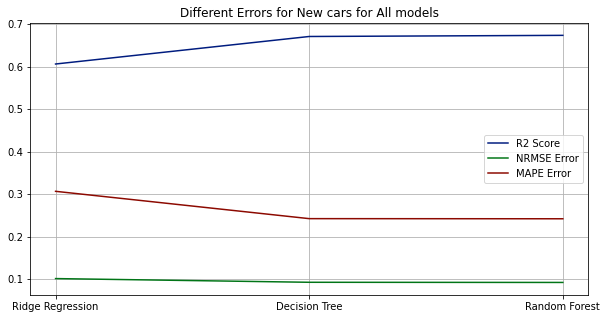

In [95]:
# Plot for New Cars
x_labels = ["Ridge Regression", "Decision Tree", "Random Forest"]
new_R2 = [r2_new_ridge_score, r2_new_DT_score, r2_new_RF_score]
new_nrmse = [nrmse_new_ridge_error, nrmse_new_DT_error, nrmse_RF_new_error]
new_mape = [mape_new_ridge_error, mape_new_DT_error,mape_RF_new]

plt.figure(figsize = (10,5))
plt.title("Different Errors for New cars for All models")
plt.xticks(ticks = [0,1,2],labels = x_labels)
plt.plot(new_R2, label = "R2 Score")
plt.plot(new_nrmse, label = "NRMSE Error")
plt.plot(new_mape, label = "MAPE Error")
plt.legend()
plt.grid()
plt.show()

So For The best model it differs from metric to other:
- NRMSE : Random Forest
- MAPE : Random Forest
- R2 : Random Forest